# 10-02-Project-Exercise

**Description:** Build a Linear Regression model for the Ames Housing dataset. Use grid search to find the optimal parameters and report the model performance scores.

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# script
from scripts.read_features import read_feature_descriptions


# Raw data import
df = pd.read_csv('data\\raw\\Ames_Housing_Data.csv')

# Read the feature files
features = read_feature_descriptions(
    "data\\raw\\Ames_Housing_Feature_Description.txt")

___
## 1. Inicial data analysis


In [3]:
df.head()

PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  526301100           20        RL         141.0     31770   Pave   NaN   
1  526350040           20        RH          80.0     11622   Pave   NaN   
2  526351010           20        RL          81.0     14267   Pave   NaN   
3  526353030           20        RL          93.0     11160   Pave   NaN   
4  527105010           60        RL          74.0     13830   Pave   NaN   

  Lot Shape Land Contour Utilities  ... Pool Area Pool QC  Fence Misc Feature  \
0       IR1          Lvl    AllPub  ...         0     NaN    NaN          NaN   
1       Reg          Lvl    AllPub  ...         0     NaN  MnPrv          NaN   
2       IR1          Lvl    AllPub  ...         0     NaN    NaN         Gar2   
3       Reg          Lvl    AllPub  ...         0     NaN    NaN          NaN   
4       IR1          Lvl    AllPub  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  SalePrice  
0        0       5    2010        WD           Normal     215000  
1        0       6    2010        WD           Normal     105000  
2    12500       6    2010        WD           Normal     172000  
3        0       4    2010        WD           Normal     244000  
4        0       3    2010        WD           Normal     189900  

[5 rows x 81 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2930 non-null   int64  
 1   MS SubClass      2930 non-null   int64  
 2   MS Zoning        2930 non-null   object 
 3   Lot Frontage     2440 non-null   float64
 4   Lot Area         2930 non-null   int64  
 5   Street           2930 non-null   object 
 6   Alley            198 non-null    object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 2      2930 non-null   object 
 15  Bldg Type        2930 non-null   object 
 16  House Style      2930 non-null   object 
 17  Overall Qual  

We can use the feature description (removing all white spaces)

In [5]:
print(f"Feature MS SubClass: {features['MSSubClass']}")
print(f"Feature Condition 1: {features['Condition1']}")

Feature MS SubClass: Identifies the type of dwelling involved in the sale.
Feature Condition 1: Proximity to various conditions


In [6]:
# PID is an unique identifier
df.PID.nunique() - len(df.index)

0

Another point is that we have an index identifier in our database called "PID", we can remove it without problems since we already have an index.

In [7]:
df = df.drop(columns="PID")

To inspect more it is necessary to search the txt file. We can do a general inspection on the numeric features

In [8]:
# Select features with type int64
numeric_features = [
    feature for feature in df.columns if df[feature].dtype in ["int64", "float64"]]

# Remove categorical features with less then 200

numeric_features = np.array(numeric_features)
numeric_features = numeric_features[(
    df[numeric_features].nunique() > 200).to_list()]

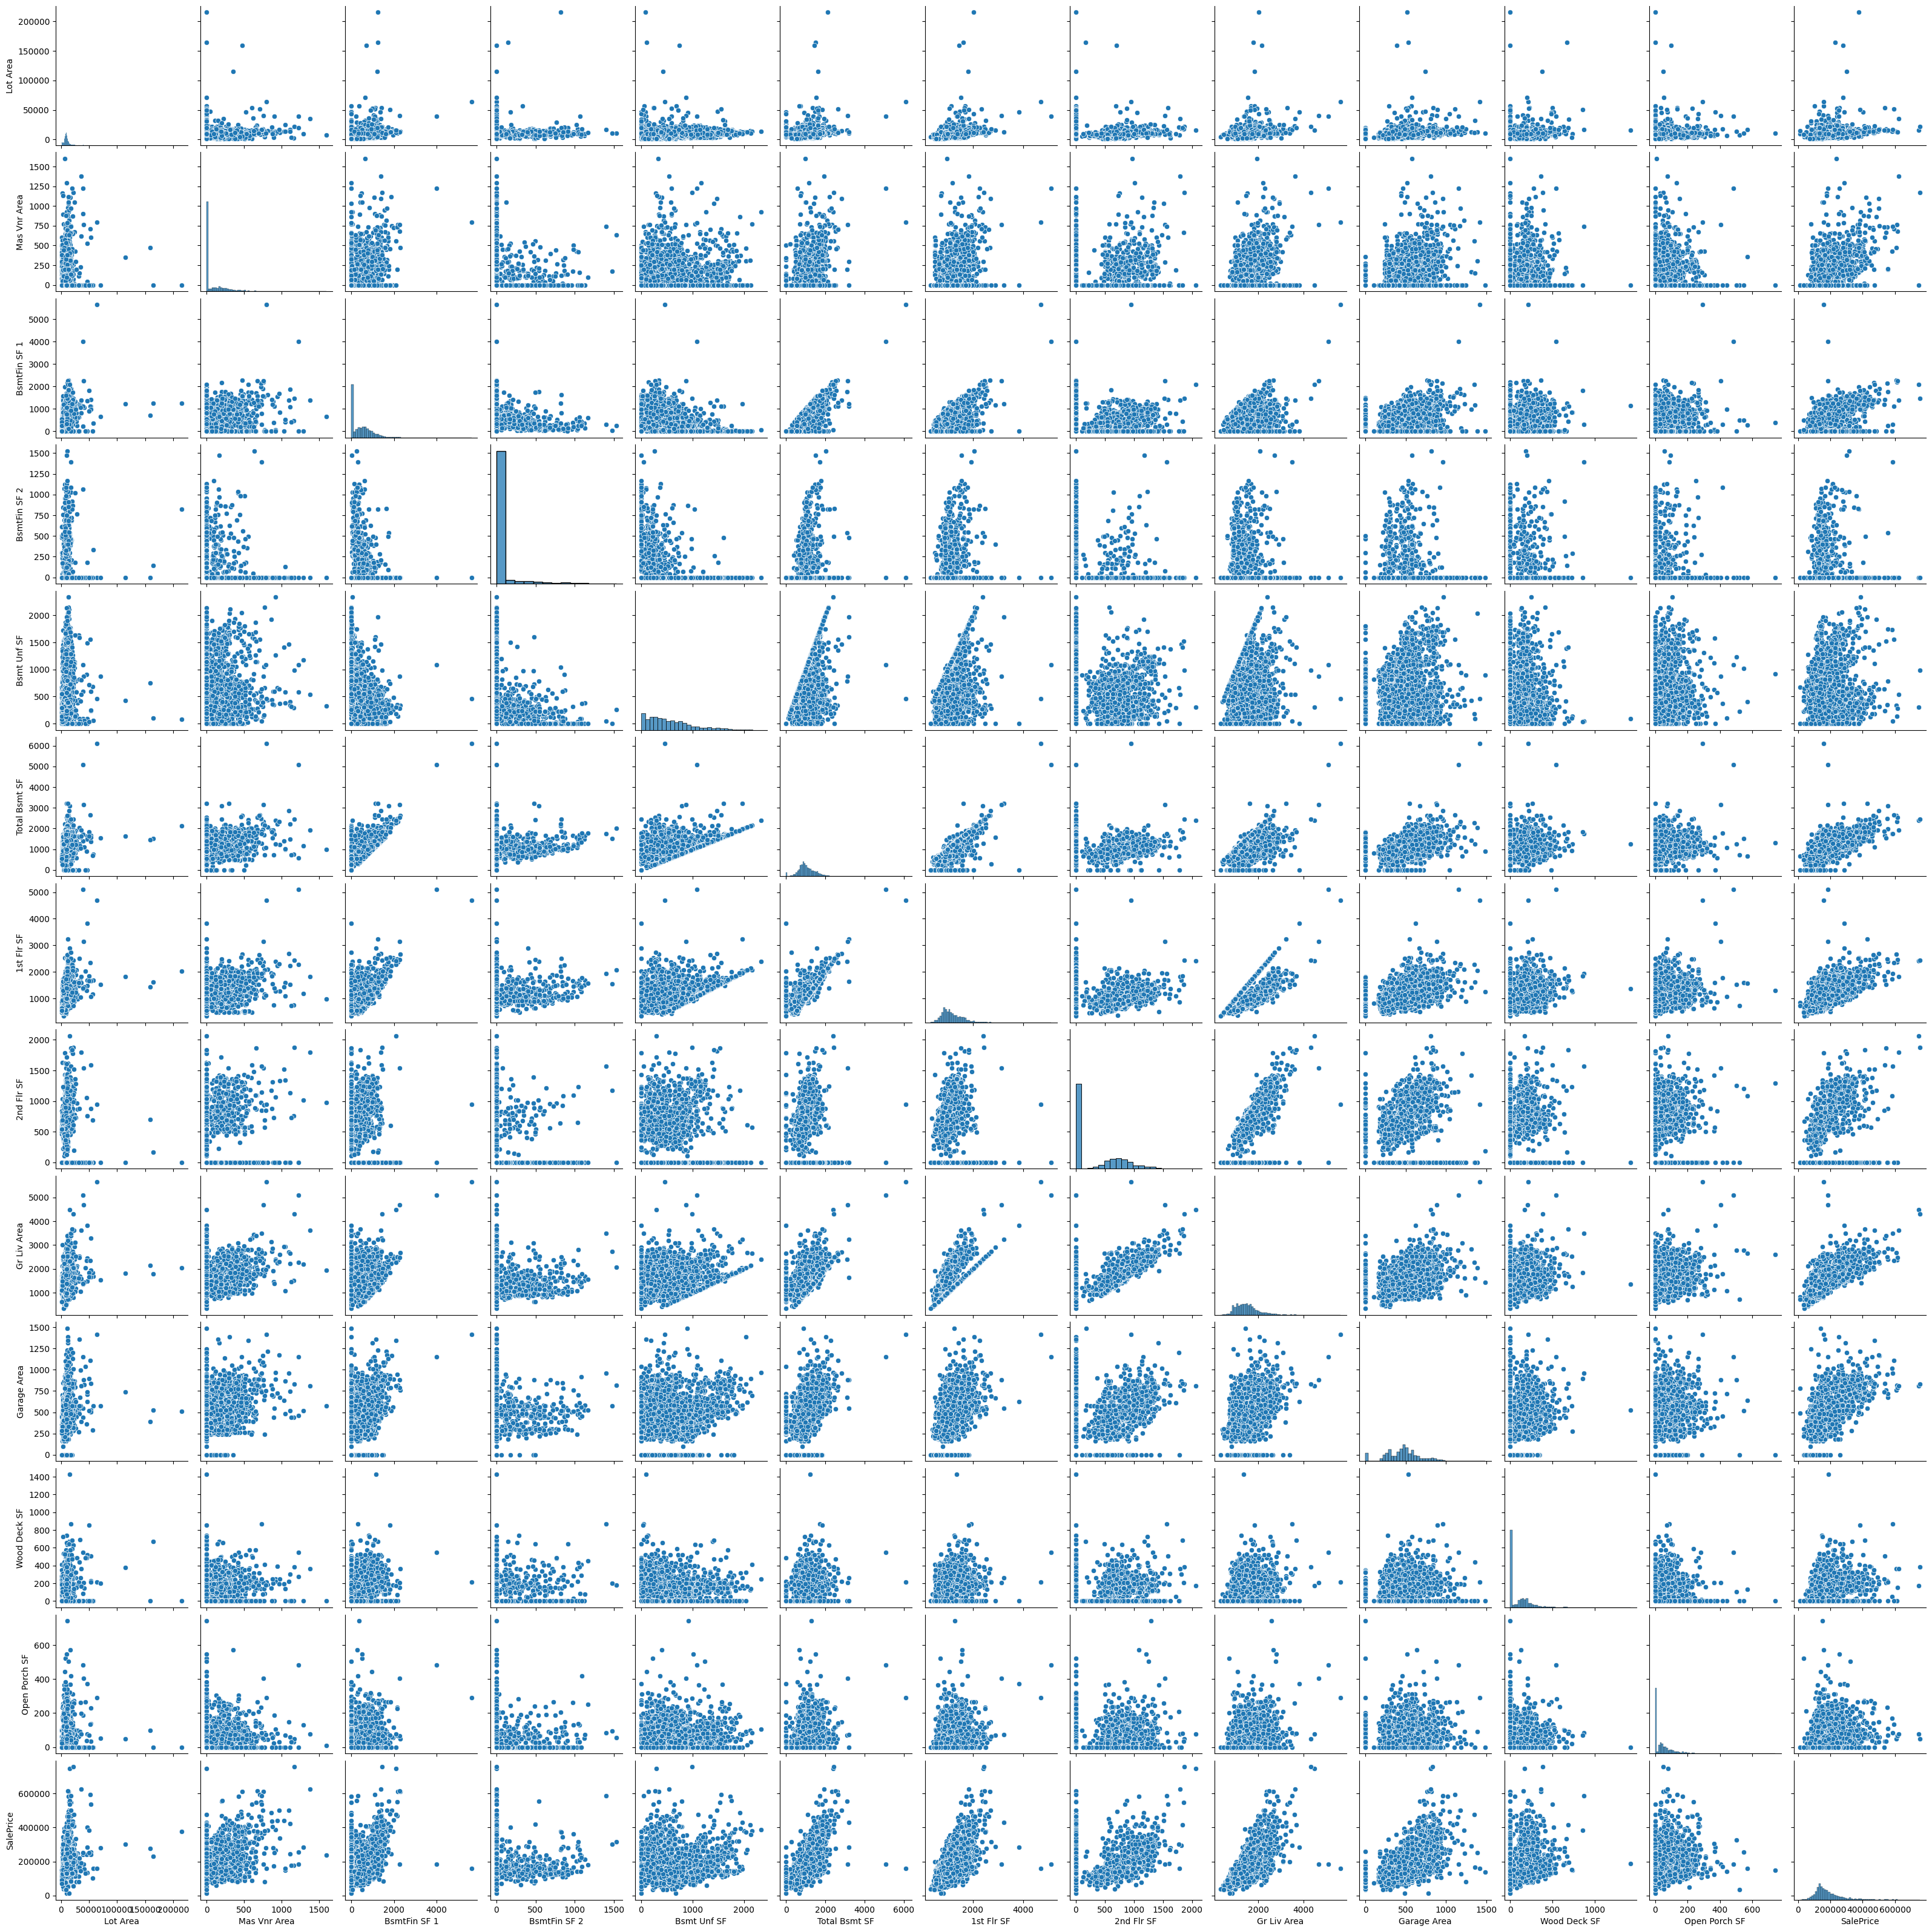

In [9]:
sns.pairplot(df[numeric_features])

___
## 2. Feature engineering
Write introduction and main points (after completing the subsections)

### 2.1 Removing outliers
Explain the objective as an introduction

We can see that some graphs appear to have outliers. The principal feature is the target of our model, SalesPrice. Lets try to remove some outliers and replot those graps.

In [10]:
# Index to drop
ind_drop = pd.Index([], dtype='int64')

# Gr Liv Area & SalePrice
ind_drop = ind_drop.append(
    df[(df['Gr Liv Area'] > 4000) & (df['SalePrice'] < 400000)].index)

# Lot Area & SalePrice
ind_drop = ind_drop.append(df[(df['Lot Area'] > 100000) &
                      (df['SalePrice'] < 400000)].index)

# Wood Deck SF & SalePrice
ind_drop = ind_drop.append(df[(df['Wood Deck SF'] > 1200) &
                      (df['SalePrice'] < 300000)].index)

# Open Porch SF & SalePrice
ind_drop = ind_drop.append(df[(df['Open Porch SF'] > 600) &
                      (df['SalePrice'] < 300000)].index)

# Copy of dropped data points
df_dropped = df.loc[ind_drop].copy(deep=True)

# Drop outliers
df = df.drop(ind_drop, axis=0)

Replotting

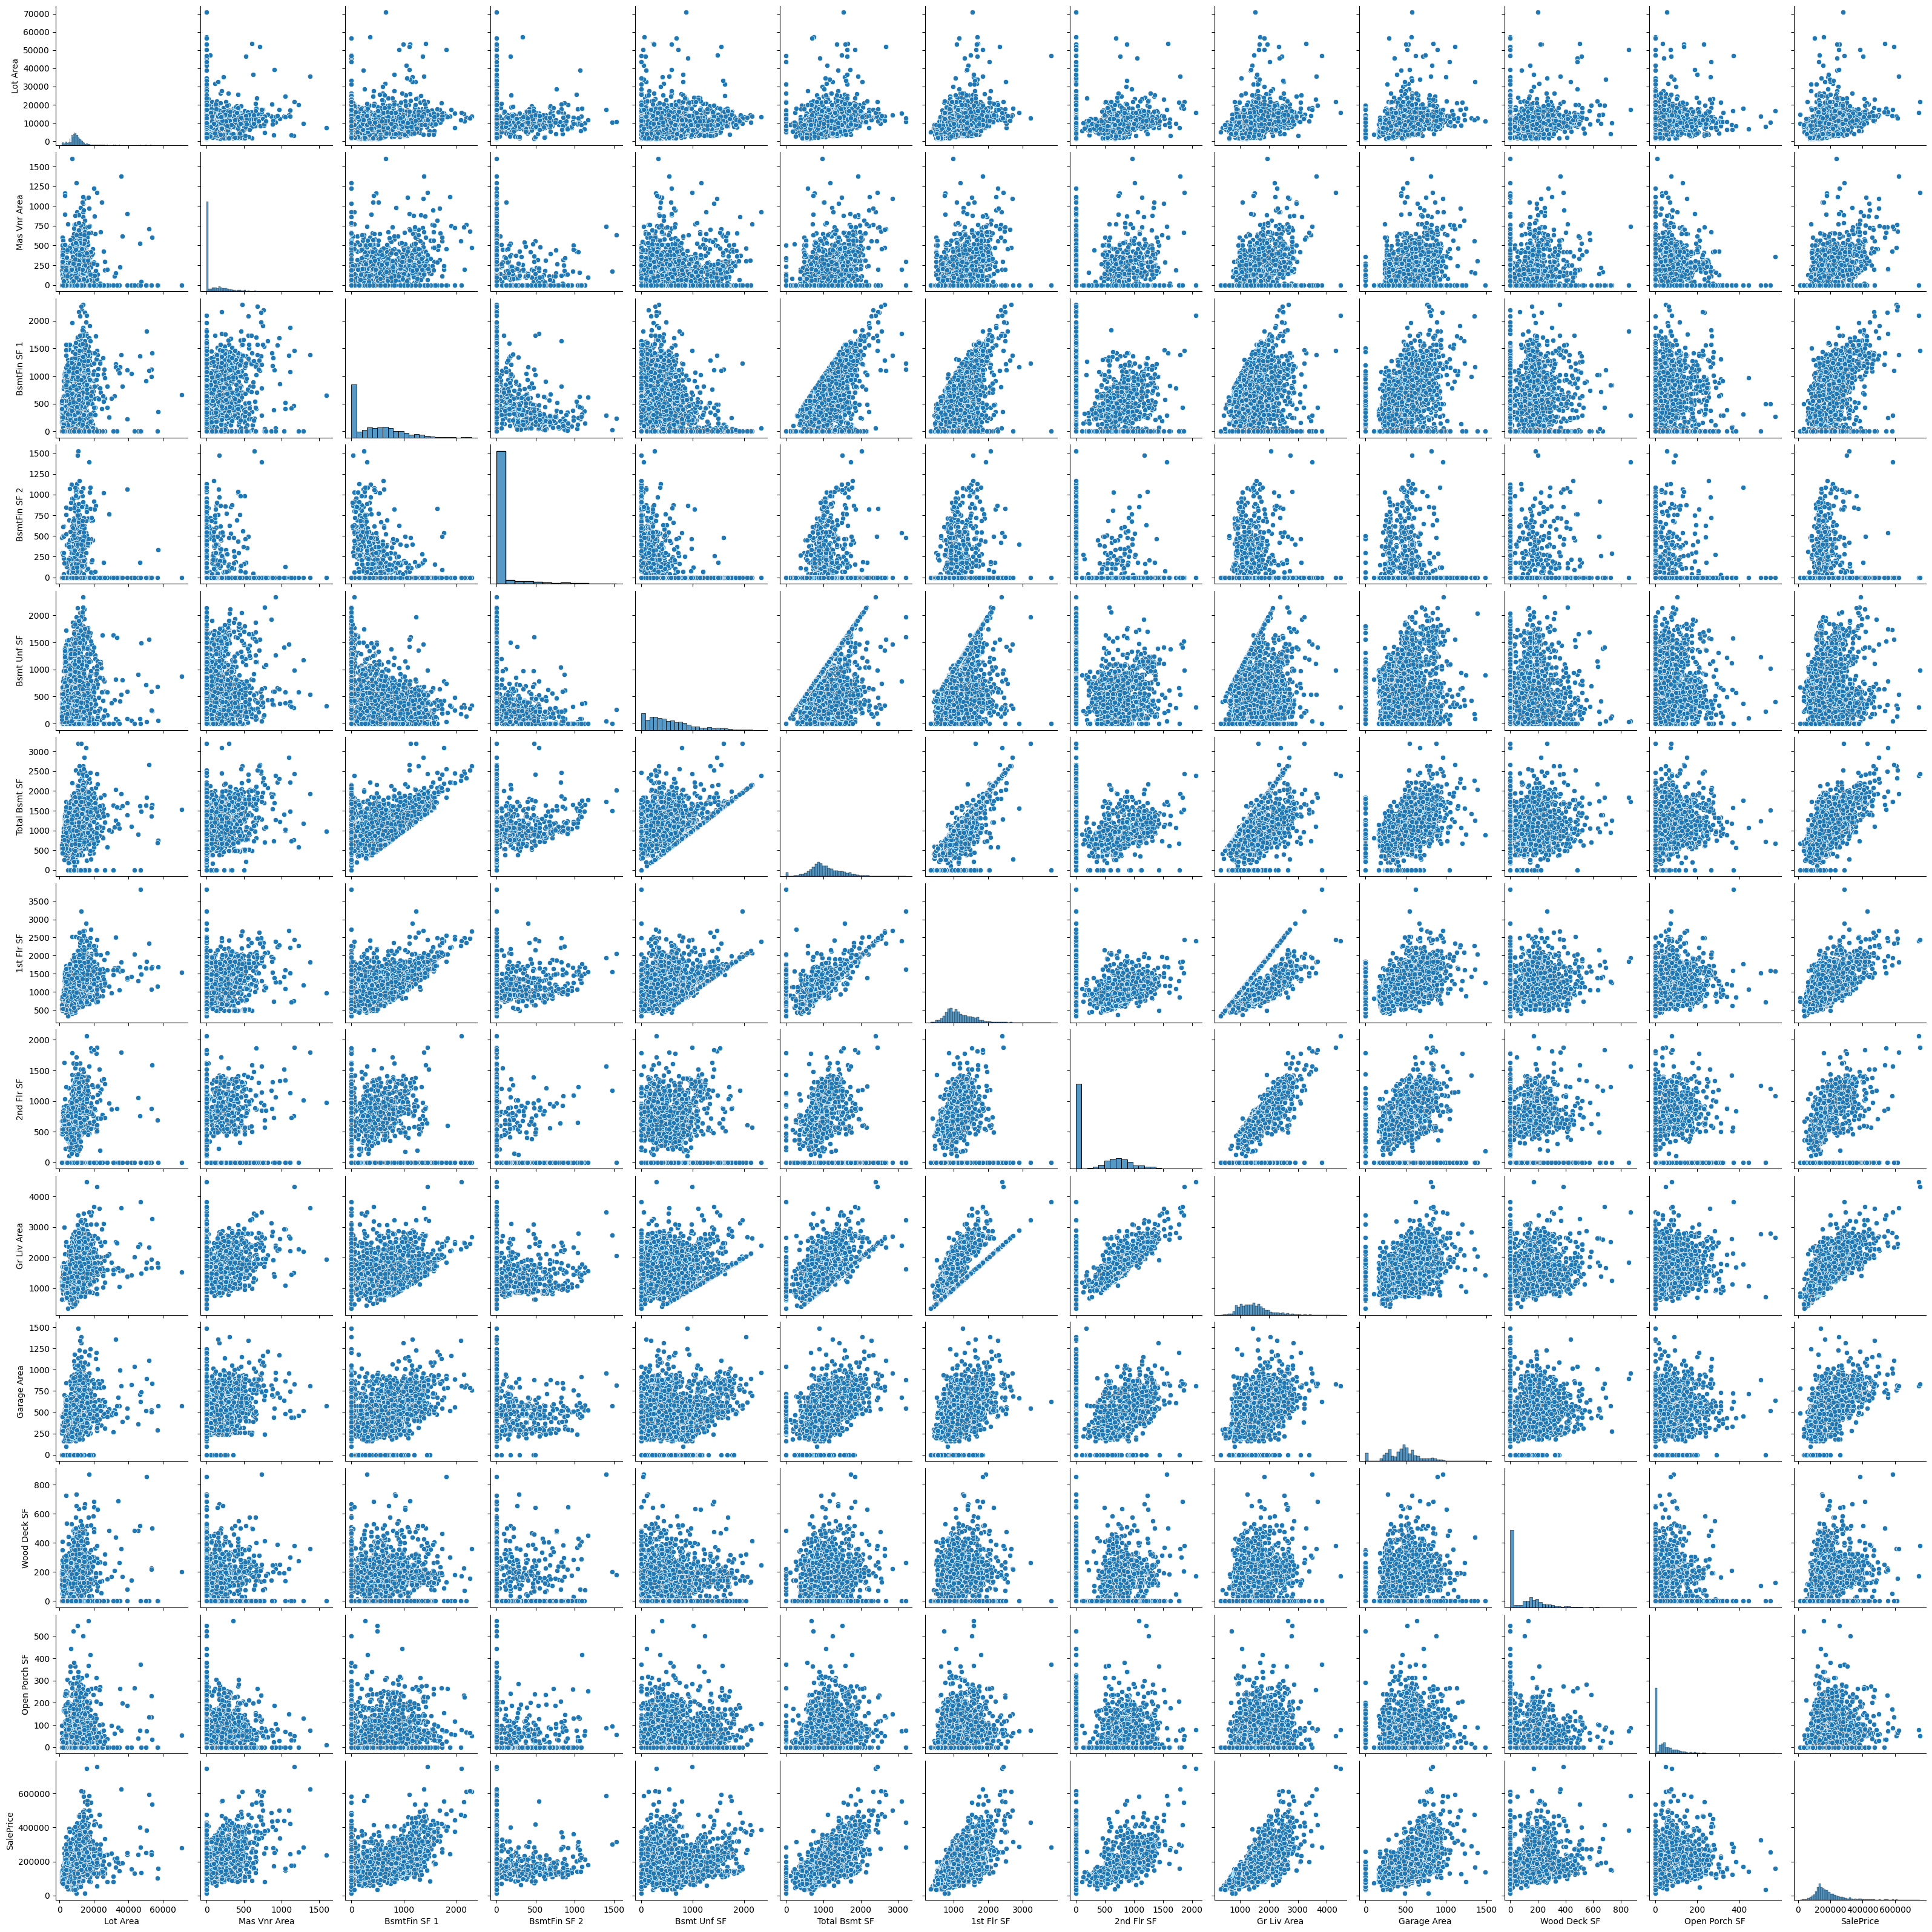

In [11]:
sns.pairplot(df[numeric_features])

### 2.2 Missing data
Explain the objective as an introduction

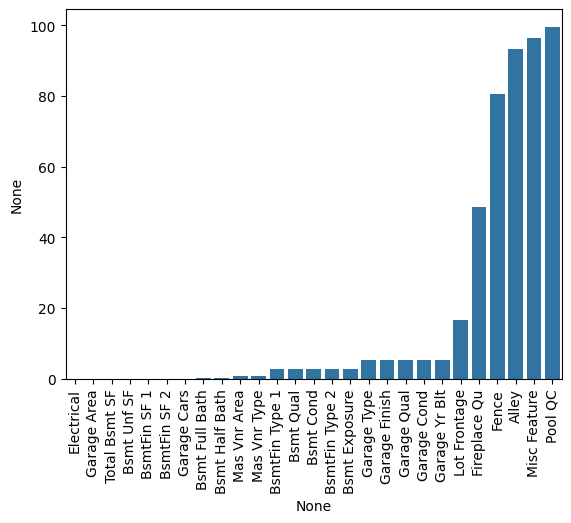

In [12]:
# Compute the percentual of missing data
y = df.isnull().sum() / len(df) * 100

# Keep only columns with missing data and sort they
y = y[y>0].sort_values()

# Plot columns with missing data
sns.barplot(x=y.index, y=y)
plt.xticks(rotation=90)

# Show plot
plt.show()


#### 2.2a Electrical
Some information we can infer from the description feature list. The first is Electrical that describe the electrical system of the propriety. Lets look at this data

In [13]:
df[df["Electrical"].isnull() == True][['Year Built', 'Year Remod/Add', 'Yr Sold', "Electrical"]]

Year Built  Year Remod/Add  Yr Sold Electrical
1577        2006            2007     2008        NaN

In [14]:
df.groupby("Yr Sold").Electrical.value_counts()

Yr Sold  Electrical
2006     SBrkr         561
         FuseA          47
         FuseF          14
         FuseP           3
2007     SBrkr         640
         FuseA          36
         FuseF          11
         Mix             1
2008     SBrkr         563
         FuseA          43
         FuseF           9
         FuseP           4
2009     SBrkr         591
         FuseA          45
         FuseF          10
         FuseP           1
2010     SBrkr         319
         FuseA          16
         FuseF           6
Name: Electrical, dtype: int64

We will fill this information using the most used Electrical system in those years

In [15]:
df.at[1577, "Electrical"] = "SBrkr"

#### 2.2b All Garage features

The description of the features appears to indicate that the missing value on those columns indicate that there are no garage on those real state. We will fill those with None for the string type feature

In [16]:
# Columns that indicate garage features and are string
garage_string_features = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']

# Fill with none string feature
df[garage_string_features] = df[garage_string_features].fillna('None')

The other columns are 'Garage Area', 'Garage Cars' and 'Garage Yr Blt'. Lets see if those missing information are on the same data

In [17]:
garage_numeric_features = ['Garage Area',
                          'Garage Cars', 'Garage Yr Blt']
df[df[garage_numeric_features].isnull().all(axis=1)]["Garage Finish"]

2236    None
Name: Garage Finish, dtype: object

We will drop this row since it is missing all those information

In [18]:
df = df.drop(2236, axis='index')

Inspecting again we see that now only the year is missing on the garage feature

In [19]:
df[garage_numeric_features].isna().sum()

Garage Area        0
Garage Cars        0
Garage Yr Blt    157
dtype: int64

Now we will use the column "Garage Finish" feature to fill the other numeric garage information. We can see that all rows that are missing Garage Yr Blt have Garage Finish set as None, using this we will fill Garage Yr Blt with zeros.

In [20]:
df[df["Garage Yr Blt"].isna()]["Garage Finish"].value_counts()

None    157
Name: Garage Finish, dtype: int64

In [21]:
df["Garage Yr Blt"] = df["Garage Yr Blt"].fillna(0)

Inspecting again

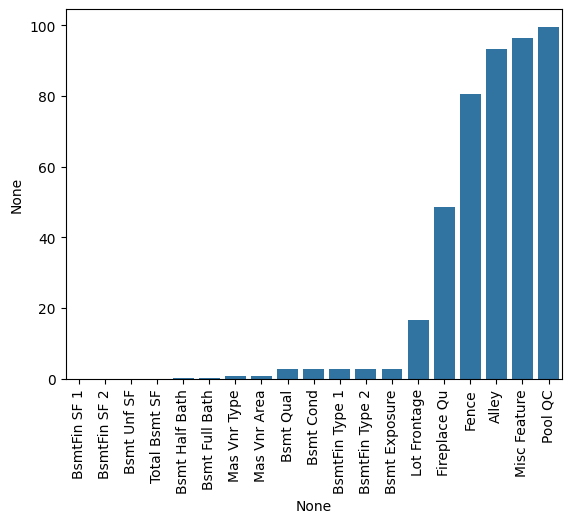

In [22]:
# Compute the percentual of missing data
y = df.isnull().sum() / len(df) * 100

# Keep only columns with missing data and sort they
y = y[y > 0].sort_values()

# Plot columns with missing data
sns.barplot(x=y.index, y=y)
plt.xticks(rotation=90)

# Show plot
plt.show()

Now all garage rows have been corrected.

#### 2.2c Basement columns

Similar to the previous garage feature the basement columns have numerical and string types. Looking at the feature description we see that all this missing information is just a placeholder for zero/none values.

In [23]:
# Basement numeric features
basement_numeric_features = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']

# Replacing with 0
df[basement_numeric_features] = df[basement_numeric_features].fillna(0)

# Basement string features
basement_string_features = ['Bsmt Qual', 'Bsmt Cond',
                'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']

# Replacing with None
df[basement_string_features] = df[basement_string_features].fillna('None')

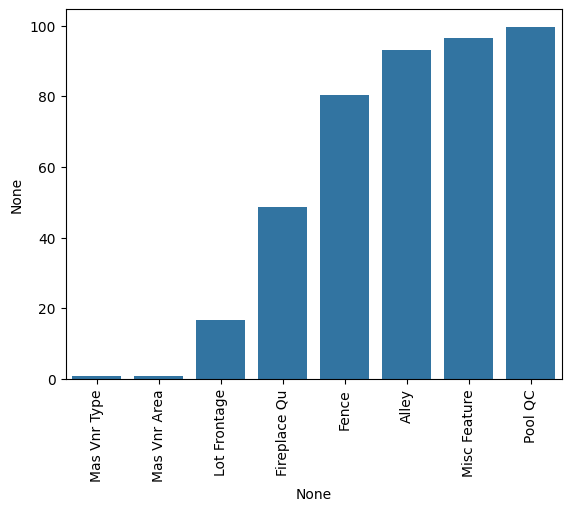

In [24]:
# Compute the percentual of missing data
y = df.isnull().sum() / len(df) * 100

# Keep only columns with missing data and sort they
y = y[y > 0].sort_values()

# Plot columns with missing data
sns.barplot(x=y.index, y=y)
plt.xticks(rotation=90)

# Show plot
plt.show()

#### 2.2d Mas Vnr Feature

Based on the Description Text File, Mas Vnr Type (Masonry veneer type) and Mas Vnr Area (Masonry veneer area in square feet) being missing (NaN) is likely to mean the house simply just doesn't have a masonry veneer, in which case, we will fill in this data as we did before.

In [25]:
# Masonry numeric features
df["Mas Vnr Area"] = df["Mas Vnr Area"].fillna(0)

# Masonry string features
df["Mas Vnr Type"] = df["Mas Vnr Type"].fillna("None")

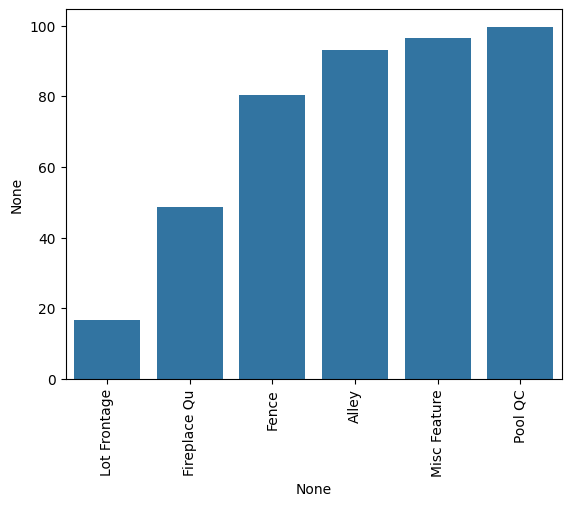

In [26]:
# Compute the percentual of missing data
y = df.isnull().sum() / len(df) * 100

# Keep only columns with missing data and sort they
y = y[y > 0].sort_values()

# Plot columns with missing data
sns.barplot(x=y.index, y=y)
plt.xticks(rotation=90)

# Show plot
plt.show()

#### 2.2e Lot Frontage

In this column is not good to just replace since all real state must have this feature. At the same time, we do not have a how to consult the original source as to ask to fill this missing data. One alternative is to impute the missing data using another feature. The idea is that this information has a correlation with another feature that we have information on.

In [27]:
df['Lot Frontage']

0       141.0
1        80.0
2        81.0
3        93.0
4        74.0
        ...  
2925     37.0
2926      NaN
2927     62.0
2928     77.0
2929     74.0
Name: Lot Frontage, Length: 2920, dtype: float64

In [28]:
# Select features with type int64
numeric_features = [
    feature for feature in df.columns if df[feature].dtype in ["int64", "float64"]]

# Correlation with numeric features
df[numeric_features].corr()['Lot Frontage'].sort_values()

MS SubClass       -0.430319
Overall Cond      -0.072278
Bsmt Half Bath    -0.028434
Yr Sold           -0.008844
Low Qual Fin SF    0.006195
Kitchen AbvGr      0.007949
Misc Val           0.014911
Mo Sold            0.016305
Enclosed Porch     0.017708
2nd Flr SF         0.023303
3Ssn Porch         0.030127
Half Bath          0.035417
BsmtFin SF 2       0.042121
Screen Porch       0.081034
Year Remod/Add     0.088508
Bsmt Full Bath     0.091313
Garage Yr Blt      0.102891
Wood Deck SF       0.115493
Year Built         0.117000
Bsmt Unf SF        0.120129
Pool Area          0.125406
Open Porch SF      0.147524
BsmtFin SF 1       0.163565
Full Bath          0.182168
Overall Qual       0.200146
Mas Vnr Area       0.202406
Fireplaces         0.242190
Bedroom AbvGr      0.248637
Total Bsmt SF      0.309789
Garage Cars        0.312520
TotRms AbvGrd      0.342430
Garage Area        0.346555
Gr Liv Area        0.355443
SalePrice          0.365419
1st Flr SF         0.430742
Lot Area           0

We can see that the best correlation is with "Lot Area" but we can visualize the correlation with categorical features also.

In [29]:
# Select features with type int64
string_features = [
    feature for feature in df.columns if df[feature].dtype == "object"]

# Remove categorical features with less then 200

string_features = np.array(string_features)
string_features = string_features[(
    df[string_features].nunique() > 10).to_list()]

In [30]:
string_features

array(['Neighborhood', 'Exterior 1st', 'Exterior 2nd'], dtype='<U14')

The one that appears to be relevant is 'Neighborhood', plotting this we have

<AxesSubplot: xlabel='Lot Frontage', ylabel='Neighborhood'>

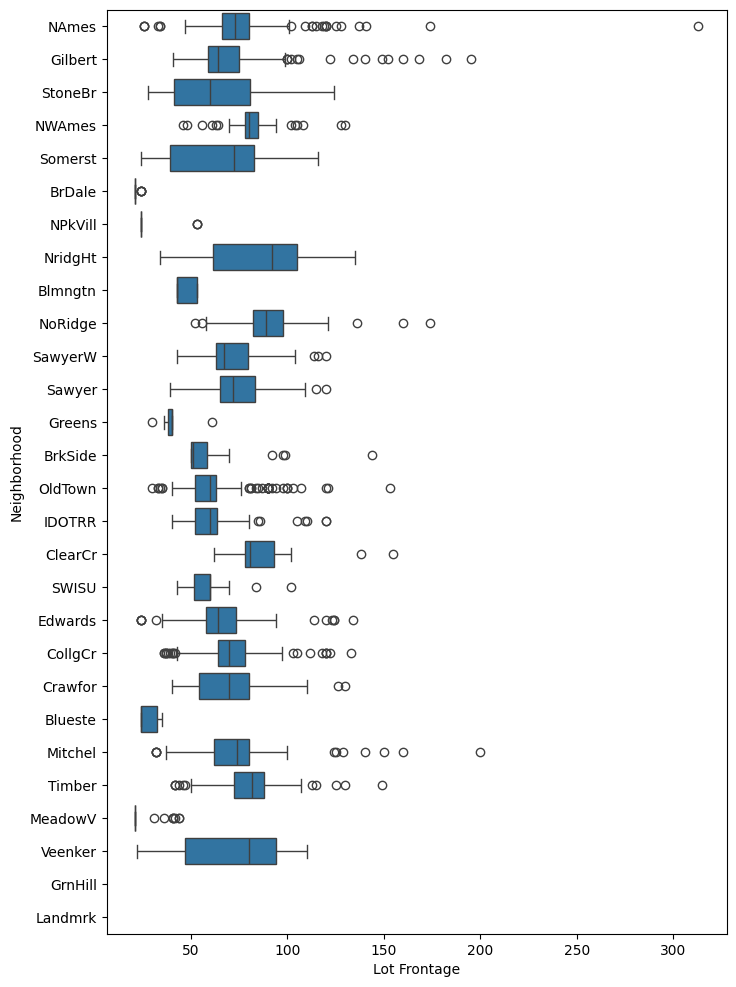

In [31]:
plt.figure(figsize=(8, 12))
sns.boxplot(x='Lot Frontage', y='Neighborhood',data=df,orient='h')

In [32]:
df[df['Lot Frontage'].notna()][['Neighborhood']].value_counts()

Neighborhood
NAmes           375
OldTown         229
CollgCr         220
Edwards         175
NridgHt         163
Somerst         162
Gilbert         111
SawyerW         106
Sawyer           98
BrkSide          95
Mitchel          90
IDOTRR           86
NWAmes           85
Crawfor          83
Timber           56
NoRidge          54
StoneBr          46
SWISU            43
MeadowV          33
BrDale           30
NPkVill          21
Blmngtn          20
ClearCr          20
Veenker          16
Blueste          10
Greens            7
dtype: int64

We will use this information to fill the missing data with

In [33]:
df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].transform(
    lambda val: val.fillna(val.mean()))

In [34]:
df[df['Lot Frontage'].isna()]

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
2256          120        RM           NaN      9763   Pave   NaN       IR1   
2788          160        RH           NaN      3612   Pave   NaN       IR1   
2892          120        RM           NaN      8239   Pave   NaN       IR1   

     Land Contour Utilities Lot Config  ... Pool Area Pool QC  Fence  \
2256          Lvl    AllPub     Inside  ...         0     NaN    NaN   
2788          Lvl    AllPub     Inside  ...         0     NaN  MnPrv   
2892          Lvl    AllPub     Inside  ...         0     NaN    NaN   

     Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  Sale Condition  \
2256          NaN        0       9     2007        WD           Normal   
2788          NaN        0       6     2006        WD           Normal   
2892          NaN        0      11     2006        WD           Normal   

      SalePrice  
2256     330000  
2788     137000  
2892     230000  

[3 rows x 80 columns]

To fill those we will use the Lot Area

In [35]:
numeric_features = [
    feature for feature in df.columns if df[feature].dtype in ["int64", "float64"]]

In [36]:
from sklearn.impute import KNNImputer
nan = np.nan

imputer = KNNImputer(n_neighbors=2, weights="uniform")
df[numeric_features] = imputer.fit_transform(df[numeric_features])

Now 

In [37]:
df[df['Lot Frontage'].isna()]

Empty DataFrame
Columns: [MS SubClass, MS Zoning, Lot Frontage, Lot Area, Street, Alley, Lot Shape, Land Contour, Utilities, Lot Config, Land Slope, Neighborhood, Condition 1, Condition 2, Bldg Type, House Style, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Roof Style, Roof Matl, Exterior 1st, Exterior 2nd, Mas Vnr Type, Mas Vnr Area, Exter Qual, Exter Cond, Foundation, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin SF 1, BsmtFin Type 2, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Heating, Heating QC, Central Air, Electrical, 1st Flr SF, 2nd Flr SF, Low Qual Fin SF, Gr Liv Area, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces, Fireplace Qu, Garage Type, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Pool QC, Fence, Misc Feature, Misc Val, Mo Sold, Yr Sold, Sale Type, Sale Condition, SalePrice]
Index: []

[0 rows x 80 columns]

### 2.3 Filling in Fireplace Quality based on Description Text

Fireplace quality also can be replaced with none

In [38]:
df['Fireplace Qu'] = df['Fireplace Qu'].fillna("None")

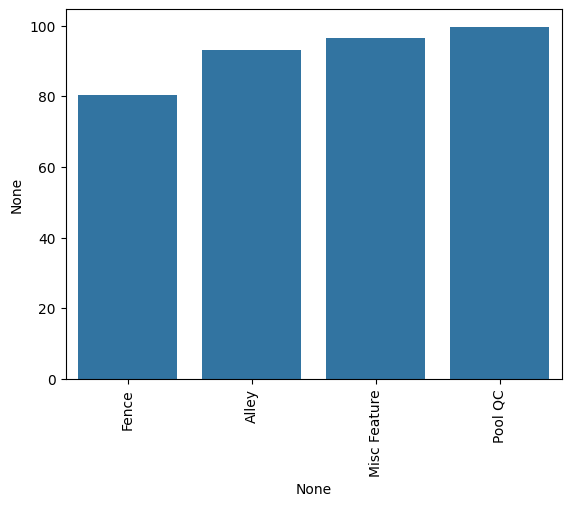

In [39]:
# Compute the percentual of missing data
y = df.isnull().sum() / len(df) * 100

# Keep only columns with missing data and sort they
y = y[y > 0].sort_values()

# Plot columns with missing data
sns.barplot(x=y.index, y=y)
plt.xticks(rotation=90)

# Show plot
plt.show()

Now we only have columns with a lot of missing data, these we should exclude from our dataset.

### 2.4 Dropping Feature columns

Sometimes you may want to take the approach that above a certain missing percentage threshold, you will simply remove the feature from all the data. For example if 99% of rows are missing a feature, it will not be predictive, since almost all the data does not have any value for it. In our particular data set, many of these high percentage NaN features are actually plasceholders for "none" or 0. But for the sake of showing variations on dealing with missing data, we will remove these features, instead of filling them in with the appropriate value.

In [40]:
df = df.drop(['Pool QC','Misc Feature','Alley','Fence'],axis=1)

In [41]:
df.isna().sum().sort_values()

MS SubClass      0
Fireplaces       0
Functional       0
TotRms AbvGrd    0
Kitchen Qual     0
                ..
Exterior 2nd     0
Exterior 1st     0
Roof Matl        0
Foundation       0
SalePrice        0
Length: 76, dtype: int64

Now out dataset is free os missing data.

### 2.5 Categorical data
Explain the objective as an introduction

#### 2.5a Numerical to categorical feature

There are some features that are numeric but the value does not represents a scale. Specially, the feature MS Sub Class is numeric encoded but this is a category feature with no sense of scale. From the description we have

    MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

Here we can see that there is no sense of scale in `20 -> 1-STORY 1946 & NEWER ALL STYLES` and `40 -> 1-STORY W/FINISHED ATTIC ALL AGES`. In the next step we will introduce dummy variables to categorical data and this should be included. So we will transform it in a string feature

In [42]:
# Convert to String
df['MS SubClass'] = df['MS SubClass'].apply(str)

#### 2.5b Creating Dummy variables from category features

In this part is best to split the dataset, create the dummy variables, and concatenate.

In [43]:
# DataFrame without objects
df_nums = df.select_dtypes(exclude='object')

# DataFrame with objects (categories)
df_objs = df.select_dtypes(include='object')

# Create dummy
df_objs = pd.get_dummies(df_objs, drop_first=True)

# Create new DataFrame with dummy and numeric columns
df_with_dummies = pd.concat([df_nums, df_objs], axis=1)

In [44]:
df_with_dummies

Lot Frontage  Lot Area  Overall Qual  Overall Cond  Year Built  \
0       141.000000   31770.0           6.0           5.0      1960.0   
1        80.000000   11622.0           5.0           6.0      1961.0   
2        81.000000   14267.0           6.0           6.0      1958.0   
3        93.000000   11160.0           7.0           5.0      1968.0   
4        74.000000   13830.0           5.0           5.0      1997.0   
...            ...       ...           ...           ...         ...   
2925     37.000000    7937.0           6.0           6.0      1984.0   
2926     75.144444    8885.0           5.0           5.0      1983.0   
2927     62.000000   10441.0           5.0           5.0      1992.0   
2928     77.000000   10010.0           5.0           5.0      1974.0   
2929     74.000000    9627.0           7.0           5.0      1993.0   

      Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  \
0             1960.0         112.0         639.0           0.0        441.0   
1             1961.0           0.0         468.0         144.0        270.0   
2             1958.0         108.0         923.0           0.0        406.0   
3             1968.0           0.0        1065.0           0.0       1045.0   
4             1998.0           0.0         791.0           0.0        137.0   
...              ...           ...           ...           ...          ...   
2925          1984.0           0.0         819.0           0.0        184.0   
2926          1983.0           0.0         301.0         324.0        239.0   
2927          1992.0           0.0         337.0           0.0        575.0   
2928          1975.0           0.0        1071.0         123.0        195.0   
2929          1994.0          94.0         758.0           0.0        238.0   

      ...  Sale Type_ConLw  Sale Type_New  Sale Type_Oth  Sale Type_VWD  \
0     ...                0              0              0              0   
1     ...                0              0              0              0   
2     ...                0              0              0              0   
3     ...                0              0              0              0   
4     ...                0              0              0              0   
...   ...              ...            ...            ...            ...   
2925  ...                0              0              0              0   
2926  ...                0              0              0              0   
2927  ...                0              0              0              0   
2928  ...                0              0              0              0   
2929  ...                0              0              0              0   

      Sale Type_WD   Sale Condition_AdjLand  Sale Condition_Alloca  \
0                 1                       0                      0   
1                 1                       0                      0   
2                 1                       0                      0   
3                 1                       0                      0   
4                 1                       0                      0   
...             ...                     ...                    ...   
2925              1                       0                      0   
2926              1                       0                      0   
2927              1                       0                      0   
2928              1                       0                      0   
2929              1                       0                      0   

      Sale Condition_Family  Sale Condition_Normal  Sale Condition_Partial  
0                         0                      1                       0  
1                         0                      1                       0  
2                         0                      1                       0  
3                         0                      1                       0  
4                         0                      1               

After the cleaning and feature engineering, we have the final data ready to use in the model. This dataset will be saved in the data\ready folder to organize and separate it from the raw data.

In [46]:
df_with_dummies.to_csv(
    'data\\ready\\processed_Ames_Housing_Data.csv', index=False)

___
## 3. Model build
Now we are ready to build our linear regression model using grid search to find the optimal parameters. First, we will load the ready data that was constructed in the previous section, and then we must create our feature matrix X and target vector y.

In [47]:
ready_df = pd.read_csv("data\\ready\\processed_Ames_Housing_Data.csv")

In [50]:
# Feature matrix X
X = ready_df.drop("SalePrice", axis=1)

# Target vector y
y = ready_df["SalePrice"]

Now we can split our data into train and test parts

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
# Split data into two sets (train and test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=101)

Since the dataset has features with distinct scales and units it is best to scale using a standard scaler. We must be careful since we only want to fit to the train set to avoid information contamination (all data must be transformed).

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
# Create instance
scaler = StandardScaler()

# Fit and transform train set
X_train = scaler.fit_transform(X_train)

# Transform test set
X_test = scaler.transform(X_test)

Now we will use an Elastic Net model, this model uses the regularizer L1 and L2

In [55]:
from sklearn.linear_model import ElasticNet

In [56]:
# Create instance
base_elastic_model = ElasticNet(max_iter=100000)

To choose the best parameters for our model we can execute a grid search. This will create a model for each combination of parameters, train the model, and compare with the others. The one that has the best result will be our final parameter choice. The parameter to choose the best model will be the negative mean square error. We will also use cross-validation of 5

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
param_grid = {'alpha':[0.1,1,5,10,50,100,150,200],
            'l1_ratio': [.1, .5, .7, .9, .95, .99, 1]}

In [59]:
# verbose number a personal preference
grid_model = GridSearchCV(estimator=base_elastic_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=0)

In [60]:
grid_model.fit(X_train,y_train)

c:\Users\Breno\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e+09, tolerance: 1.309e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\Breno\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e+09, tolerance: 1.387e+09
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100, 150, 200],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error')

New we can extract the best parameters of our grid search.

In [61]:
grid_model.best_params_

{'alpha': 150, 'l1_ratio': 1}

Now we can use the test data to get the realistic metric of our model. We will use the best model to predict on the X_test.

In [62]:
y_pred = grid_model.predict(X_test)

Now that we have our predictions we can compare with the expected result, y_test. We will use the metric mean error and mean absolute error 

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [64]:
# Mean absolute error (MAE)
mean_absolute_error(y_test,y_pred)

14877.100361645827

In [67]:
# Compute mean squared error (MSE)
mean_squared_error(y_test,y_pred)

472354447.27603066

In [68]:
# Compute root mean squared error (RMSE)
np.sqrt(mean_squared_error(y_test, y_pred))

21733.716830676494

Those are the final results of our model:

- MAE: 14877.10
- MSE: 472354447.28
- RMSE: 21733.72

We expect that our model will be off the mark by approximately 21,733.72 dollars. We can use the mean of prices to inspect how large this error is proportionally.

In [70]:
np.sqrt(mean_squared_error(y_test, y_pred))/np.mean([ready_df['SalePrice']]) * 100

12.030067087205586

This indicates that our error is in the order of 12%. Further refinement and exploration using other models can probably reduce this error.